# Setup

In [1]:
# settings
from scanpy_helpers import *
print ('scanpy version: {}'.format(sc.__version__))
warnings.filterwarnings('ignore')
%matplotlib inline

# download data from s3
wkdir = '/home/ubuntu/data/DL20181011_melanocyte_test_data'
s3dir = 'daniel.le-work/MEL_project'
for file in ['primary_mel_rawdata_181011.csv','primary_mel_metadata_181011.csv']:
    ! aws s3 cp --quiet s3://{s3dir}/{file} {wkdir}/

# read raw data (expression data) to pandas df
pre_adata = pd.read_csv('{}/primary_mel_rawdata_181011.csv'.format(wkdir))

# read annotation data
anno = pd.read_csv('{}/primary_mel_metadata_181011.csv'.format(wkdir))

scanpy version: 1.3.2+78.g5034872


# Ingest data protocol
- Raw data and annotation CSV provided by Ashley Maynard
- Append gene marker expression
- Subsequently, ERCC-associated gene names are removed.

In [2]:
raw_adata = create_adata(pre_adata)
anno_dict = {'age':'age',
             'plate':'plate',
             'location':'Anatomical_location',
             'race':'Race',
             'sex':'Sex',
             'color':'sample_color',
             'patient':'patient_id'}
append_anno(raw_adata, anno, anno_dict)
append_markers(raw_adata, gene_markers=['PMEL','KRT1','KRT5','KRT10','TYR','MITF','HRH2'])
raw_adata = remove_ercc(raw_adata) 

Ingest raw data...
	Cells: 4356, Genes: 26485
Append annotations...
	Cells: 4356, Genes: 26485
Append marker gene expresssion...
Remove ERCC genes...
Filtered genes: 11
	Cells: 4356, Genes: 26474


# Cohort analysis
- Determine general statistics
- Determine feature class statistics

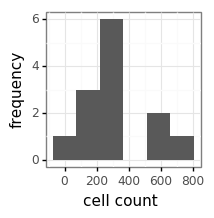

<ggplot: (8744013961613)>


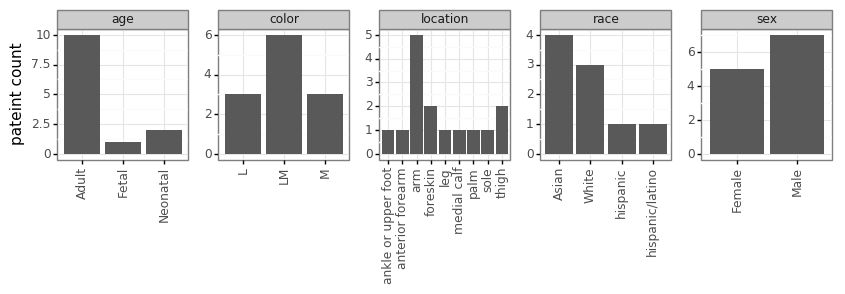

<ggplot: (8744012721479)>


In [3]:
input_data = raw_adata

# Cell distribution among patients
plot_data = list(input_data.obs.groupby('patient').count()['plate'])
df = pd.DataFrame({'counts':plot_data})

plotnine.options.figure_size = (2,2)
print(ggplot(df, aes(x='counts'))+
     theme_bw() +
     theme(aspect_ratio=1)+
    geom_histogram()+
    labs(x='cell count', y='frequency'))

# Patient distribution among classes
count_list = []
label_list = []
group_list = []
for feat in ['age','color','sex','race','location']:
    count_list = count_list + input_data.obs.groupby(by=feat).nunique()['patient'].values.tolist()
    labels = input_data.obs.groupby(by=feat).nunique().index.tolist()
    label_list = label_list + labels
    group_list = group_list + [feat for x in range(len(labels))]
df = pd.DataFrame({'group':group_list,'key':label_list,'count':count_list})

plotnine.options.figure_size = (10, 10)
print(ggplot(df, aes('key','count'))+
     theme_bw() +
     theme(aspect_ratio=1,
          axis_text_x=element_text(angle=90),
          panel_spacing_x=0.3) +
    geom_bar(stat='identity', position='dodge') +
    facet_wrap('~group', scales='free', nrow = 1) +
    labs(y='pateint count', x=''))

# All-cells analysis
- Filter cells/genes: min-reads, min-genes, and dispersion range
- Scale/transform expression values
- PCA dimensionality reduction
- Cluster by diffusion-like random walk
- Louvain community detection
- UMAP plot

Process expression data...
	Initial values:
	Cells: 4356, Genes: 26474
min counts per cell(min_counts): 50000
min genes per cell(min_genes): 500
min expression dispersion(min_disp): 0.1
min mean expression(min_mean): 0.001
max mean expression(max_mean): 1000.0
Filtered cells: 45
Filtered genes: 15764
	Final values:
	Cells: 4311, Genes: 10710
Principle component analysis...


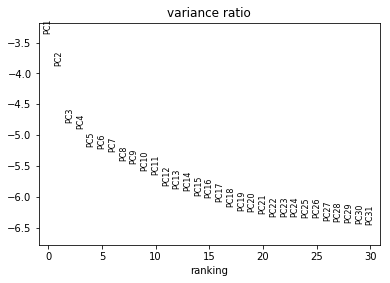

Enter number of principle components to use:
20
principle_components(num_pcs): 20
cells/neighborhood(hoods): 30
Uniform manifold approximation and projection...
	Scan Louvain detection resolutions
	resolution_interval(step_size): 0.05


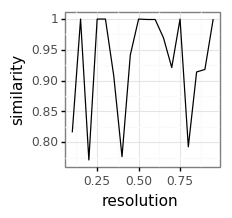

<ggplot: (-9223363292838591835)>
Enter Louvain detection resolution to use:
0.8
resolution(res): 0.8
... storing 'age' as categorical
... storing 'plate' as categorical
... storing 'location' as categorical
... storing 'race' as categorical
... storing 'sex' as categorical
... storing 'color' as categorical
... storing 'patient' as categorical


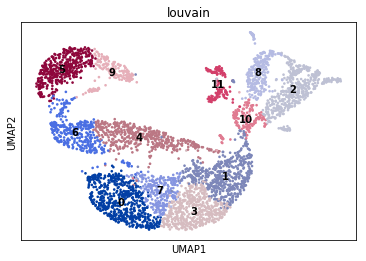

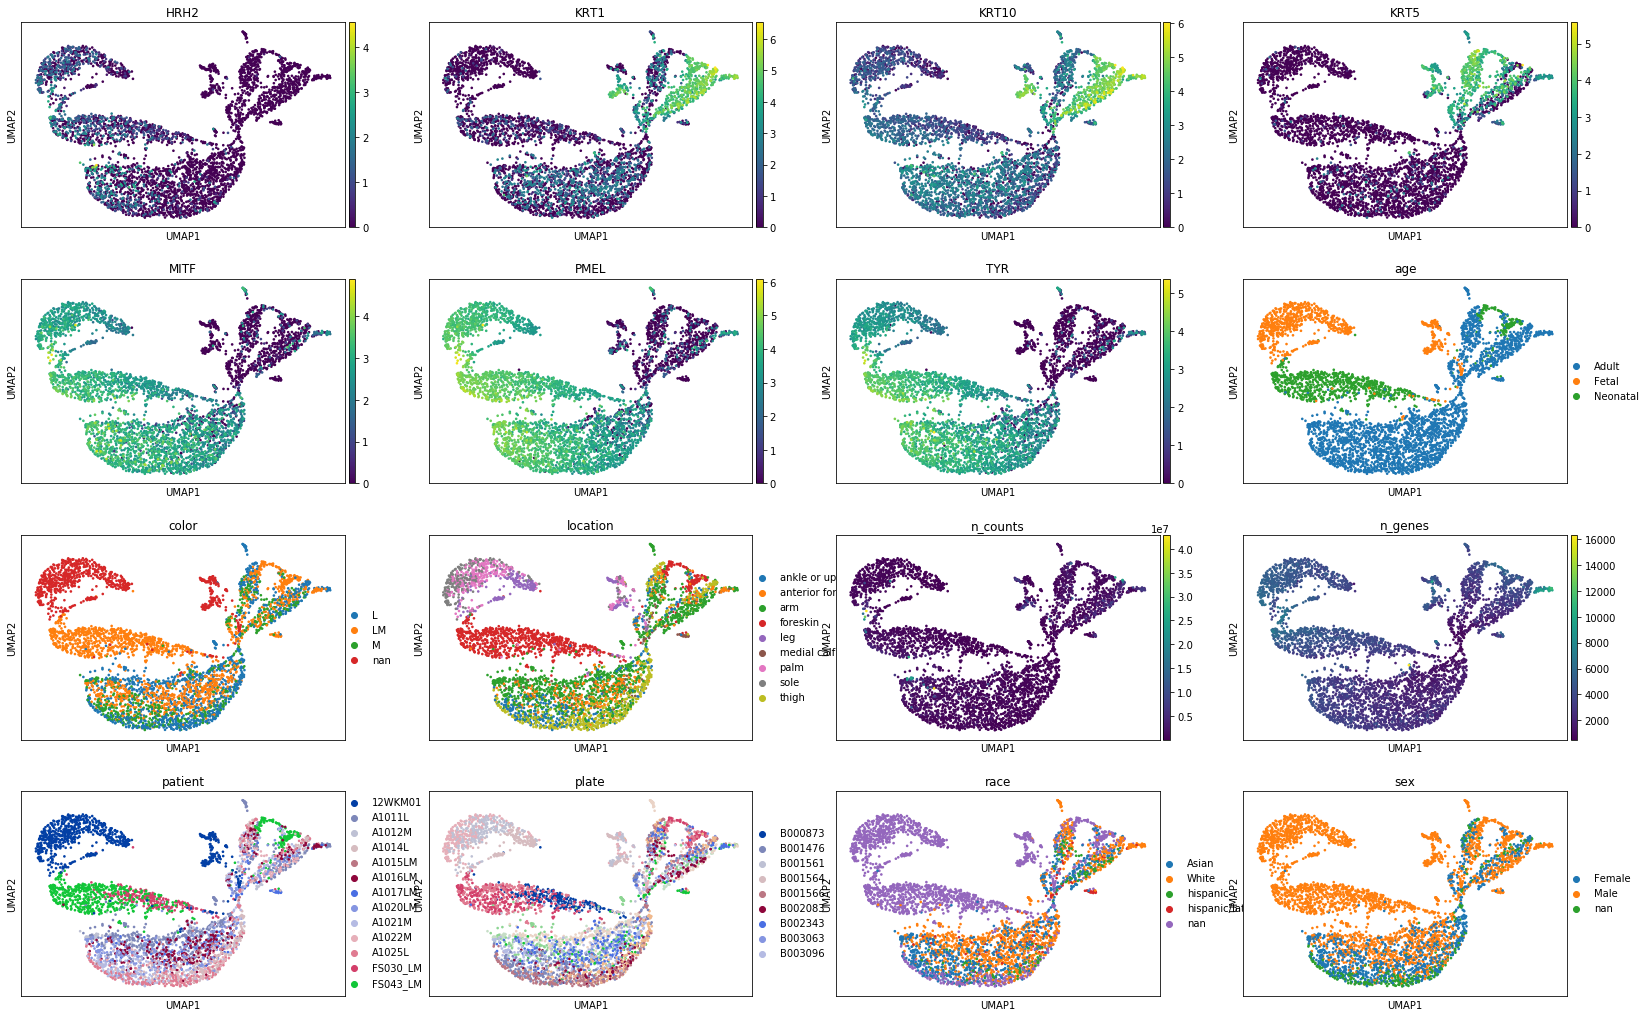

In [4]:
full_adata = process_adata(raw_adata)
pca_adata(full_adata)
umap_adata(full_adata)

# Classify MEL vs KRT
- Manual classification based on marker gene expression

In [5]:
# create list of louvain cluster for each cell label
KRT_int = [2,8,10,11]
MEL_int = [0,1,3,4,5,6,7,9]
type_dict = {'KRT':[str(x) for x in KRT_int],
             'MEL':[str(x) for x in MEL_int]}

# DUB_int = [9]
# type_dict = {'KRT':[str(x) for x in KRT_int],
#              'MEL':[str(x) for x in MEL_int],
#              'DUB':[str(x) for x in DUB_int]}
    
classify_type(raw_adata, full_adata, type_dict)

# Subset and re-analyze
- Subset filter based on categorical clinical metadata and assigned cluster: age, location, race, sex, ratio_label, color, patient, louvain

Subsetting data...
key = age, value = Adult, matched = 2658
key = type, value = KRT, matched = 1038
	Cells: 742, Genes: 26474
Process expression data...
	Initial values:
	Cells: 742, Genes: 26474
min counts per cell(min_counts): 50000
min genes per cell(min_genes): 500
min expression dispersion(min_disp): 0.1
min mean expression(min_mean): 0.001
max mean expression(max_mean): 1000.0
Filtered cells: 0
Filtered genes: 17056
	Final values:
	Cells: 742, Genes: 9418
Principle component analysis...


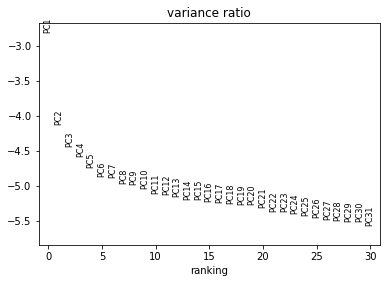

Enter number of principle components to use:
10
principle_components(num_pcs): 10
cells/neighborhood(hoods): 30
Uniform manifold approximation and projection...
	Scan Louvain detection resolutions
	resolution_interval(step_size): 0.05


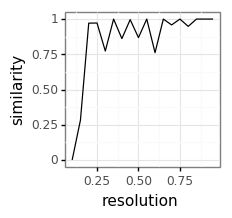

<ggplot: (8744017142557)>
Enter Louvain detection resolution to use:
0.6
resolution(res): 0.6
... storing 'age' as categorical
... storing 'plate' as categorical
... storing 'location' as categorical
... storing 'race' as categorical
... storing 'sex' as categorical
... storing 'color' as categorical
... storing 'patient' as categorical
... storing 'type' as categorical


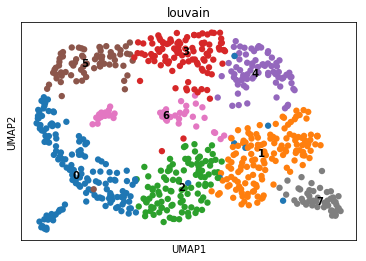

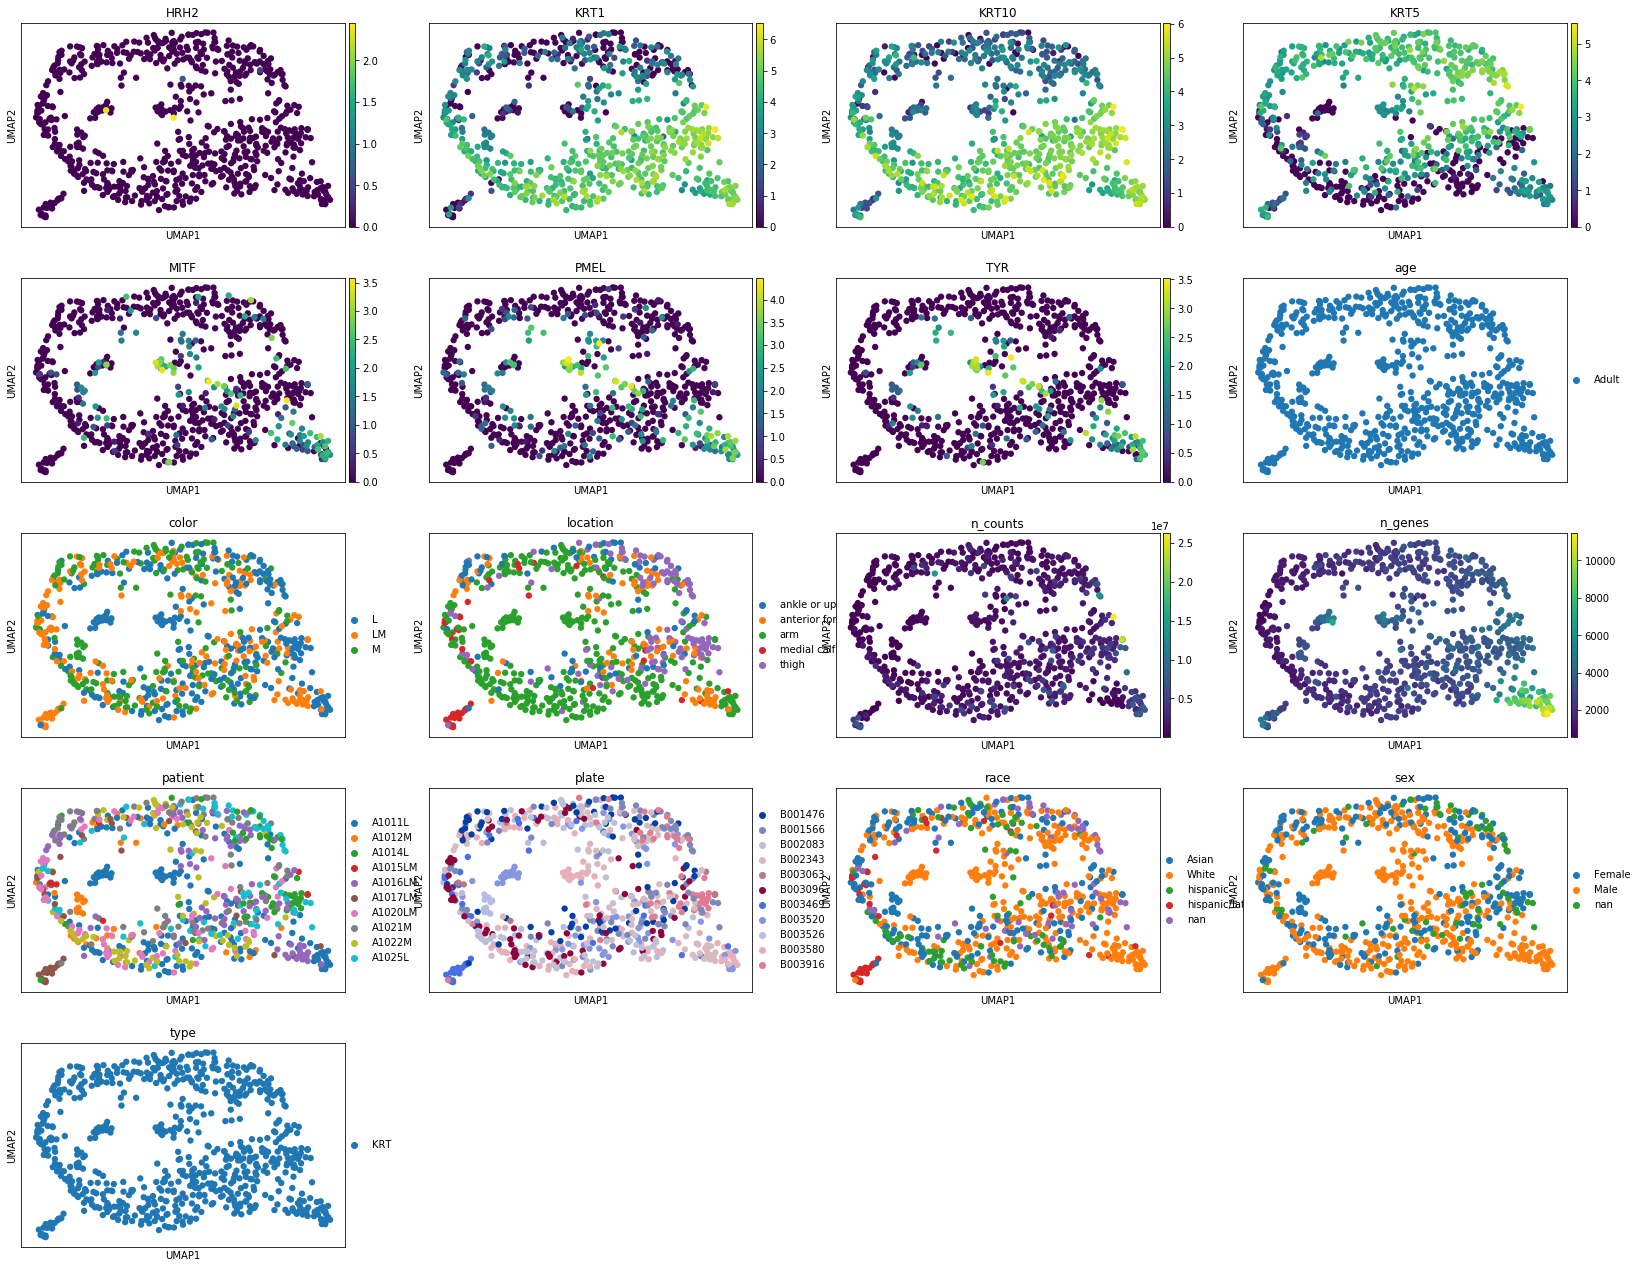

In [17]:
feature_dict = {'age':['Adult'], 'type':['KRT']}
adata_subset = subset_adata(raw_adata, feature_dict)
adata_subset = process_adata(adata_subset)
pca_adata(adata_subset)
umap_adata(adata_subset)

# Quantify class covariance
- High degree of covariation indicates dependent classes

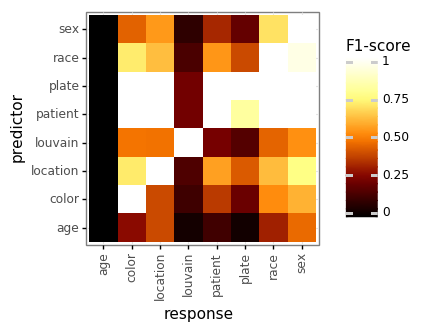

<ggplot: (8744014201748)>

In [21]:
# correlation among features
input_data = adata_subset

fltrd_labels = [key for key,value in anno_dict.items()] + ['louvain']
df = pd.DataFrame()   
for label_col in fltrd_labels:
    acc_list = []
    for label_row in fltrd_labels:
        acc_list.append(class2class_reg(X=input_data.obs[label_row], y=input_data.obs[label_col]))
    df['{}'.format(label_col)] = acc_list
df['predictor'] = fltrd_labels
# print(df)

plotnine.options.figure_size = (3,3)
plot_df = pd.melt(df, id_vars=['predictor'])
(ggplot(plot_df, aes('variable','predictor',fill='value')) +
     theme_bw() +
     theme(aspect_ratio=1,
          axis_text_x=element_text(angle=90)) +
     geom_tile() +
     labs(x='response', y='predictor', fill='F1-score')+
    scale_fill_cmap(name='afmhot'))

# Differential gene expression rank per cluster
- Rank enriched genes per cluster

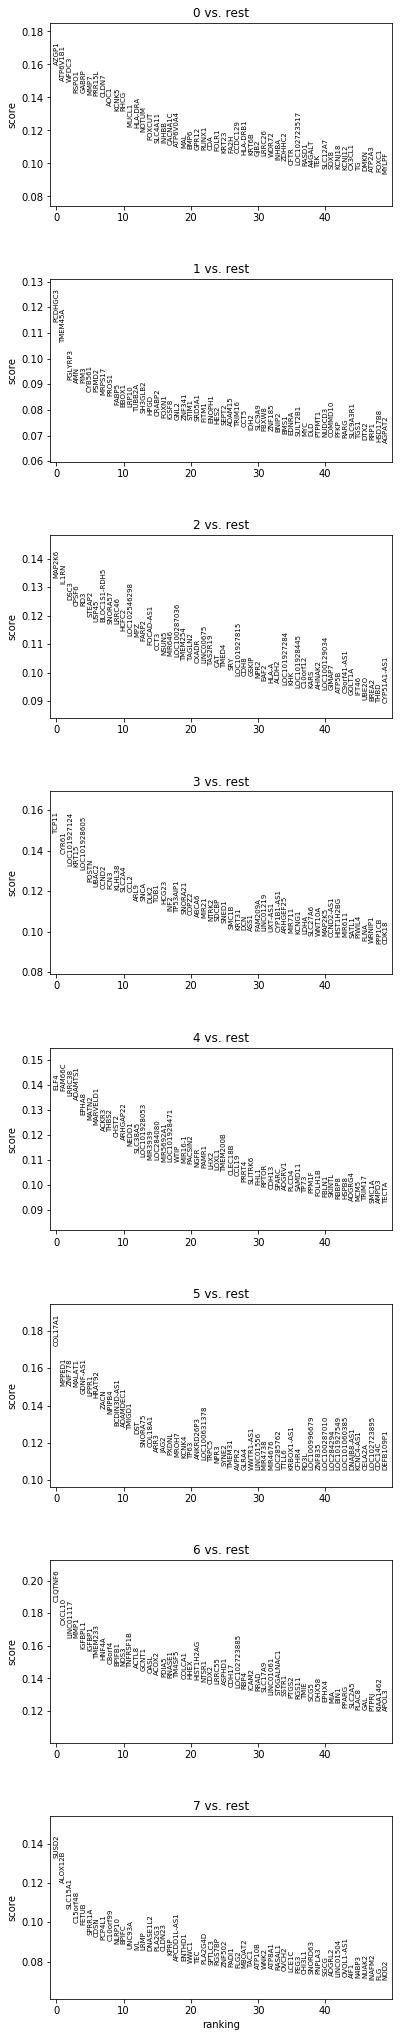

https://s3-us-west-2.amazonaws.com/daniel.le-work/MEL_project/subset_rank_genes.csv
          0        1             2             3         4            5  \
0     AZGP1  PCDHGC3        MAP2K6         TCP11      ELF4      COL17A1   
1  ATP6V1B1  TMEM45A         IL1RN         CYR61    FAM66C       MPPED1   
2     WFDC3  PGLYRP3          DSC3  LOC101927124    LRRC38       ZNF778   
3     RSPO1      AMN         CPSF6         KRT15   ADAMTS1       MALAT1   
4     GABRP     PIM3           RD3  LOC101928605     EPHA8     GDNF-AS1   
5      MMP7   CYB561        STEAP2         POSTN     MATN2        LPPR1   
6    PRR15L    PSMD2         USP45         UBAC2  MARVELD1       HRAT92   
7     CLDN7   MRPS17  BLOC1S1-RDH5         CCND2     ACKR3         ZACN   
8      AOC1    PROS1       SNORA57          FCN3     THBS2       NPIPB4   
9     KCNK5    FABP5        LRRC46        KLHL38     CHST2  BCDIN3D-AS1   

           6         7  
0    C1QTNF6     SUSD2  
1     CXCL10   ALOX12B  
2  LINC01117   

In [19]:
# Rank genes
input_adata = adata_subset
sc.tl.rank_genes_groups(input_adata, 'louvain', method='logreg')
sc.pl.rank_genes_groups(input_adata, n_genes=50, sharey=False, n_panels_per_row=1, fontsize=7)

# save df to S3 and publish link
df_rank = pd.DataFrame(input_adata.uns['rank_genes_groups']['names'])
rank_fn = 'subset_rank_genes.csv'
df_rank.to_csv('{}/{}'.format(wkdir, rank_fn))
! aws s3 cp --quiet {wkdir}/{rank_fn} s3://{s3dir}/ # push to s3
dl_link = 'https://s3-us-west-2.amazonaws.com/{}/{}'.format(s3dir,rank_fn)
HTML_cmd = "<a href='{}' target='_blank'>top100_ranked_genes</a>".format(dl_link) 
display(HTML(HTML_cmd)) # publish link
print(dl_link)
print(df_rank.head(10))